In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 26.6MB/s 
     |████████████████████████████████| 1.2MB 45.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 204kB 52.8MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.all import *

## The Data

In [4]:
creds = '{"username":"avidiotic","key":"82fd2cded77da3c693d5404352f495d9"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.mk_write(creds)
    cred_path.chmod(0o600)

In [5]:
!kaggle datasets download nikitarom/planets-dataset

100% 1.49G/1.50G [00:13<00:00, 134MB/s]
100% 1.50G/1.50G [00:13<00:00, 122MB/s]


In [7]:
!unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [9]:
path = Path('planet/planet')

In [10]:
path.ls()

(#4) [Path('planet/planet/train-jpg'),Path('planet/planet/test-jpg'),Path('planet/planet/train_classes.csv'),Path('planet/planet/sample_submission.csv')]

In [52]:
df_train = pd.read_csv(path/'train_classes.csv')
print(len(df_train))
df_train.head()

40479


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [66]:
df_small = df_train.head(5000)
len(df_small)

5000

In [23]:
img_path = path/'train-jpg'/'train_2.jpg'
img = PILImage.create(img_path)
img.shape

(256, 256)

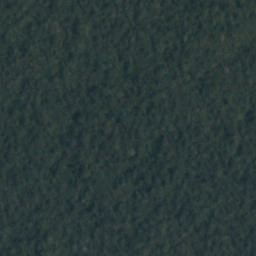

In [27]:
img.to_thumb(256)

## Creating a Datablock and DataLoaders

In [33]:
def get_images(x):
    file_name = x['image_name'] + '.jpg'
    img_path = path/'train-jpg'/file_name
    return img_path

images = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = get_images,
    get_y = lambda r: r['tags'].split(),
    splitter = RandomSplitter(valid_pct=0.2),
    batch_tfms = aug_transforms(min_scale=0.75)
)

In [67]:
dls = images.dataloaders(df_small)

In [55]:
x,y = first(dls.train)
x.shape, y.shape

(torch.Size([64, 3, 233, 233]), torch.Size([64, 17]))

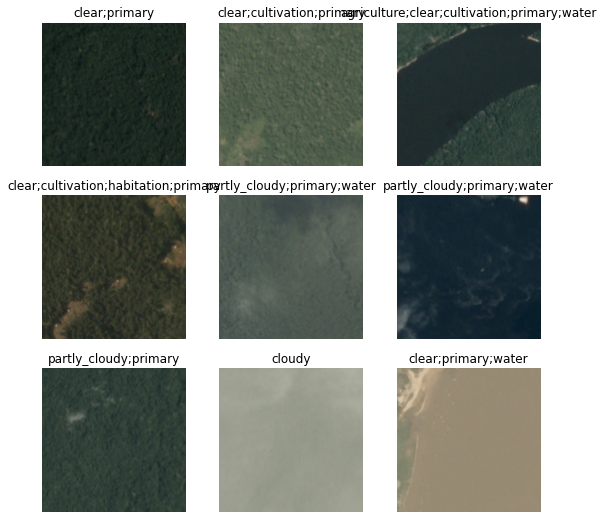

In [61]:
dls.show_batch(nrows=3, ncols=3)

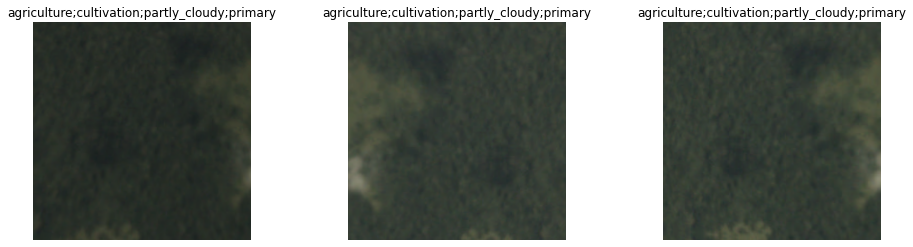

In [45]:
dls.show_batch(max_n=3, nrows=1, unique=True, figsize=(16, 4))

## Defining the accuracy function

In [46]:
def accuracy_multi(inp, targ, thres=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp > thres) == targ.bool()).float().mean()

## Creating a learner and identifying a good threshold

In [68]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.033113110810518265)

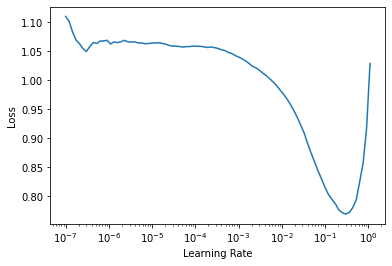

In [65]:
learn.lr_find()

In [69]:
learn.fine_tune(3, base_lr=3e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.607365,0.202048,0.938706,00:31
1,0.277015,0.164297,0.941353,00:32
2,0.193429,0.145843,0.945647,00:31
3,0.161257,0.136086,0.948824,00:31


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.146719,0.169652,0.943412,00:42
1,0.134120,0.120588,0.951941,00:42
2,0.116201,0.101967,0.961294,00:42


In [70]:
preds, targs = learn.get_preds()

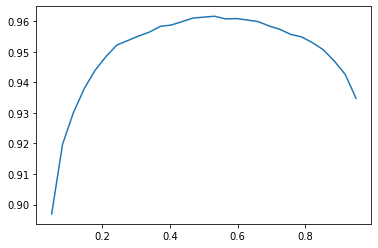

In [72]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thres=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [73]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)
learn.fine_tune(6, base_lr=3e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.607165,0.197086,0.938176,00:32
1,0.274358,0.159832,0.942353,00:31
2,0.192630,0.148557,0.943529,00:31
3,0.159872,0.133229,0.950235,00:31


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136529,0.145188,0.946647,00:42
1,0.136085,0.134198,0.948529,00:42
2,0.125279,0.125877,0.952176,00:42
3,0.116555,0.105820,0.958941,00:42
4,0.107601,0.102075,0.961529,00:42
5,0.097887,0.098607,0.962412,00:42
